22.11.4984
boybe jan mada kusuma

https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment/code

In [ ]:
pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import optuna

In [ ]:
df = pd.read_csv('/content/updated_pollution_dataset.csv')

In [ ]:
df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good


In [ ]:


df.tail()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
4995,40.6,74.1,116.0,126.7,45.5,25.7,2.11,2.8,765,Hazardous
4996,28.1,96.9,6.9,25.0,25.3,10.8,1.54,5.7,709,Moderate
4997,25.9,78.2,14.2,22.1,34.8,7.8,1.63,9.6,379,Moderate
4998,25.3,44.4,21.4,29.0,23.7,5.7,0.89,11.6,241,Good
4999,24.1,77.9,81.7,94.3,23.2,10.5,1.38,8.3,461,Moderate


In [ ]:


cat = df.select_dtypes(include=['object']).columns
num = df.select_dtypes(include=['int', 'float']).columns



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


PRE PROCESSING

In [ ]:


df.duplicated().sum()



0

In [ ]:
# Memeriksa missing values di setiap kolom

missing_values = df.isnull().sum()
missing_values

,0
Temperature,0
Humidity,0
PM2.5,0
PM10,0
NO2,0
SO2,0
CO,0
Proximity_to_Industrial_Areas,0
Population_Density,0
Air Quality,0


Berdasarkan analisis data, tidak ditemukan nilai yang hilang (NaN) atau duplikasi data. Oleh karena itu, tidak diperlukan tindakan pembersihan data lebih lanjut pada dataset ini.

EDA

In [ ]:
def eda_univariate_numeric(df):
    numeric_columns = df.select_dtypes(include=['number']).columns

    for col in numeric_columns:
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')
        plt.ylabel(col)

        plt.tight_layout()
        plt.show()

def eda_univariate_categorical(df):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    for col in categorical_columns:
        plt.figure(figsize=(12, 6))

        sns.countplot(x=df[col], order=df[col].value_counts().index, palette='viridis')
        plt.title(f'Countplot of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

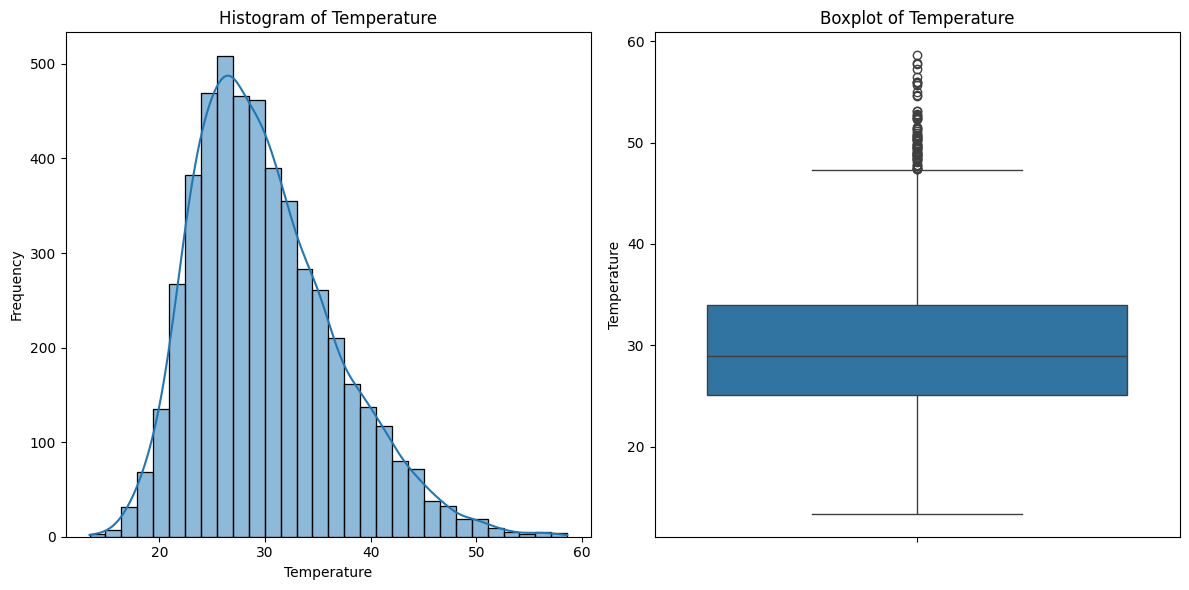

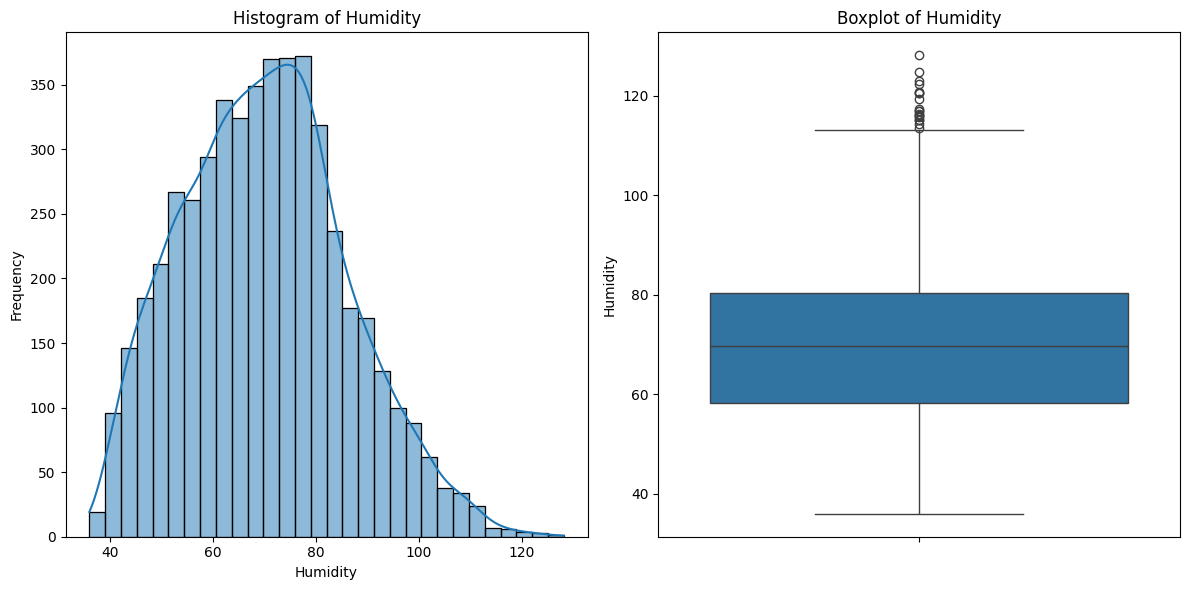

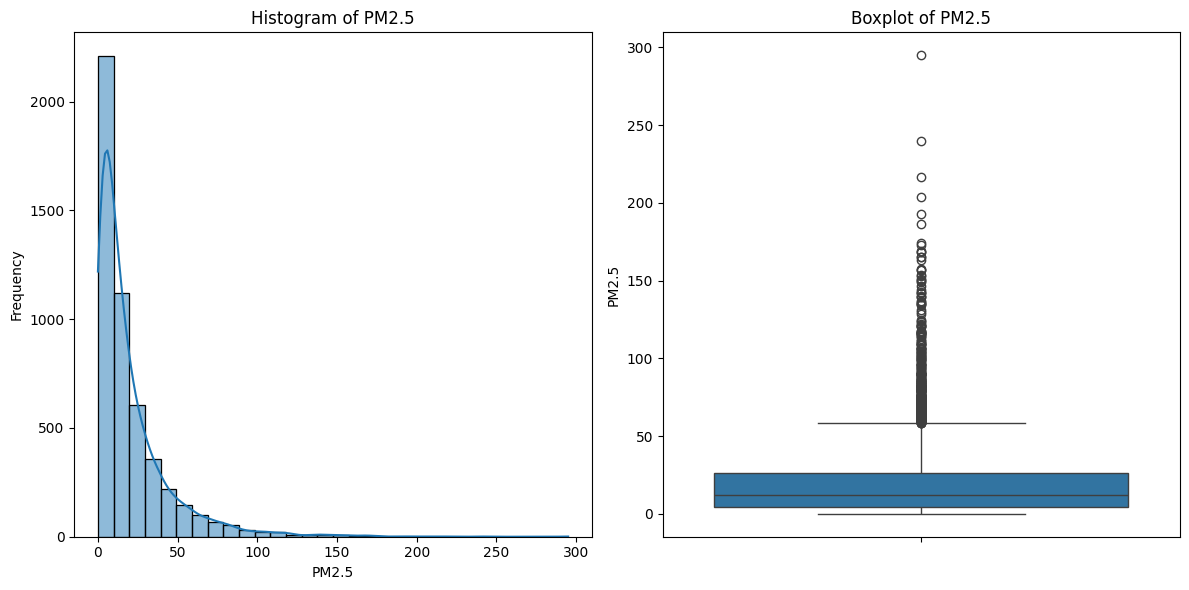

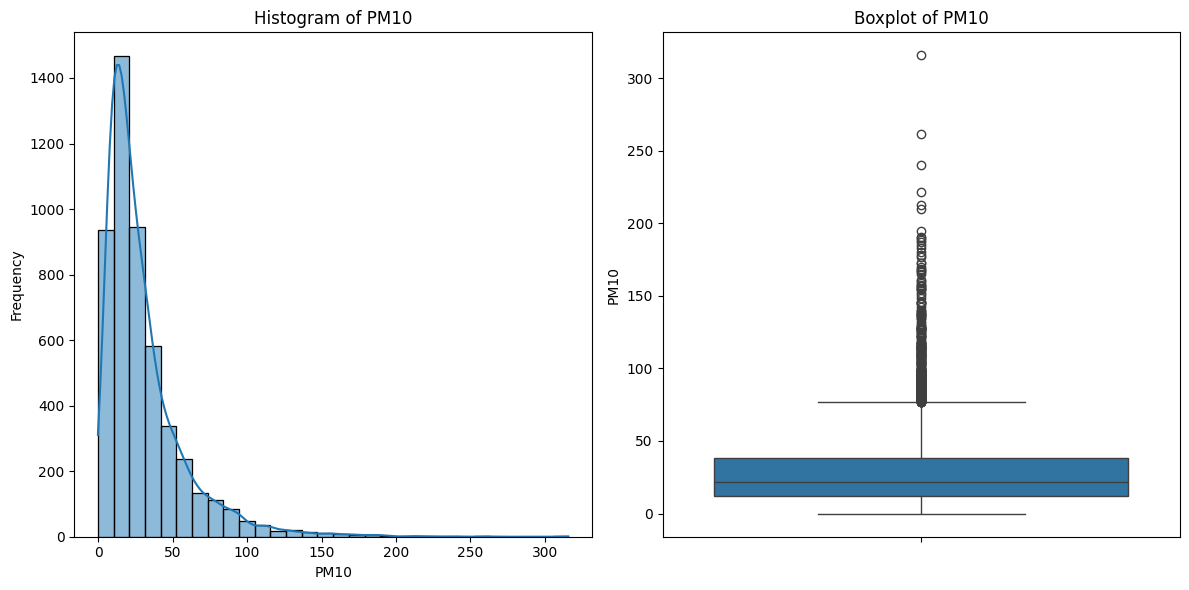

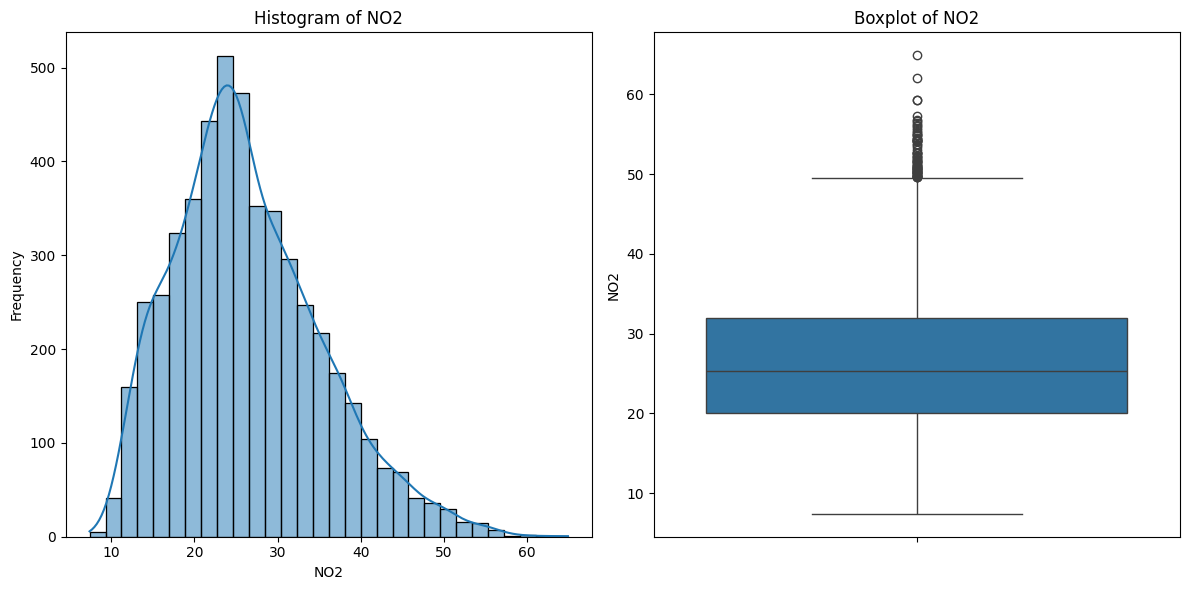

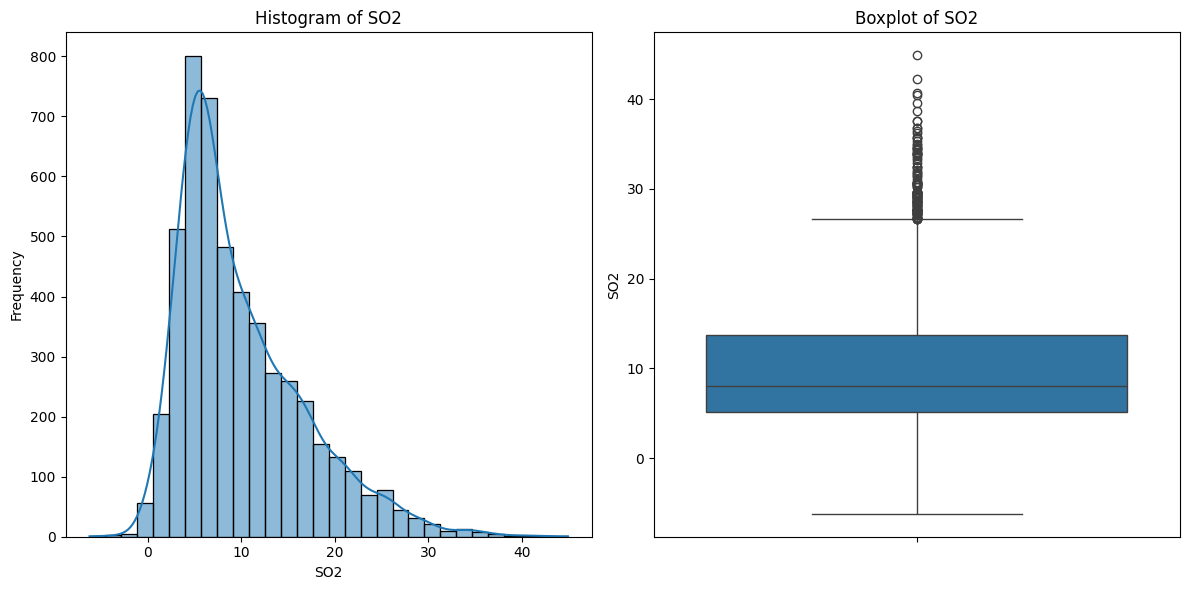

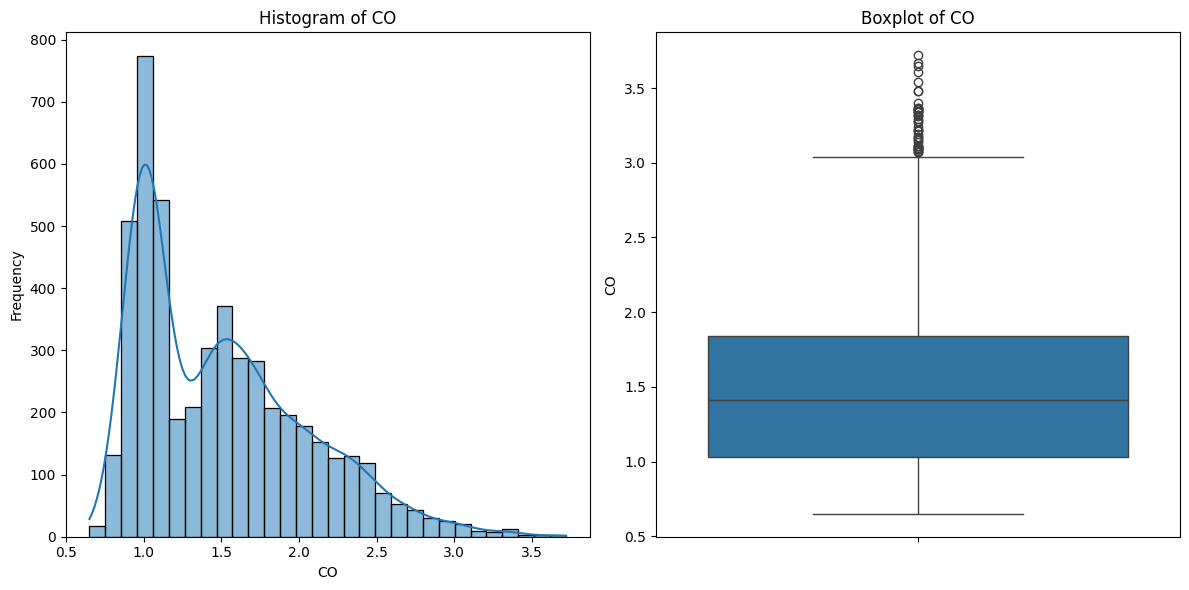

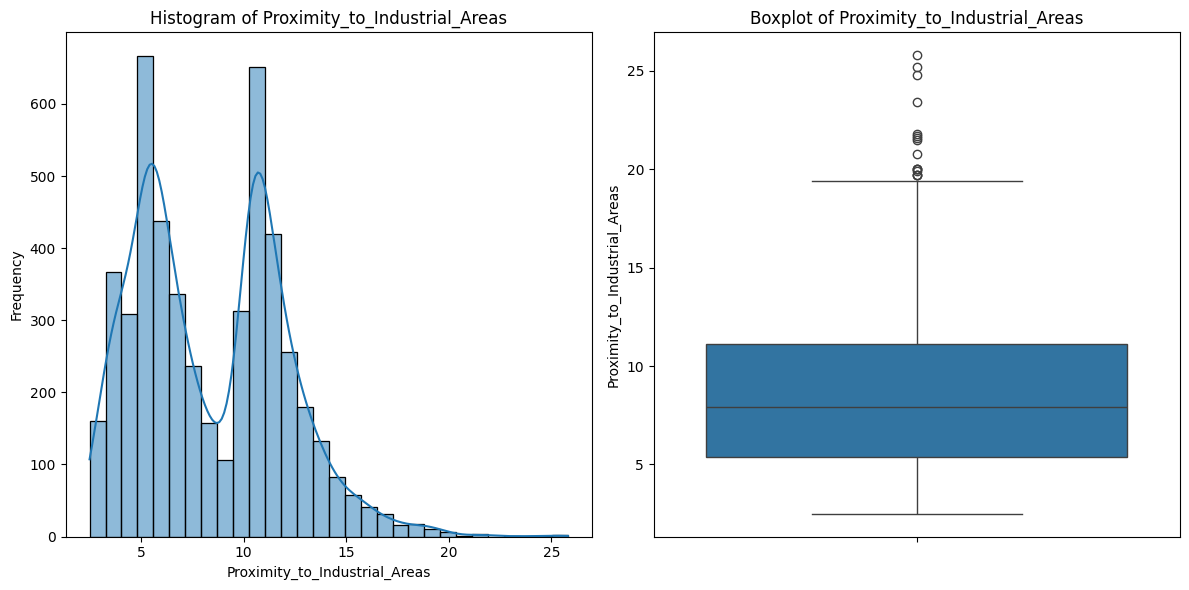

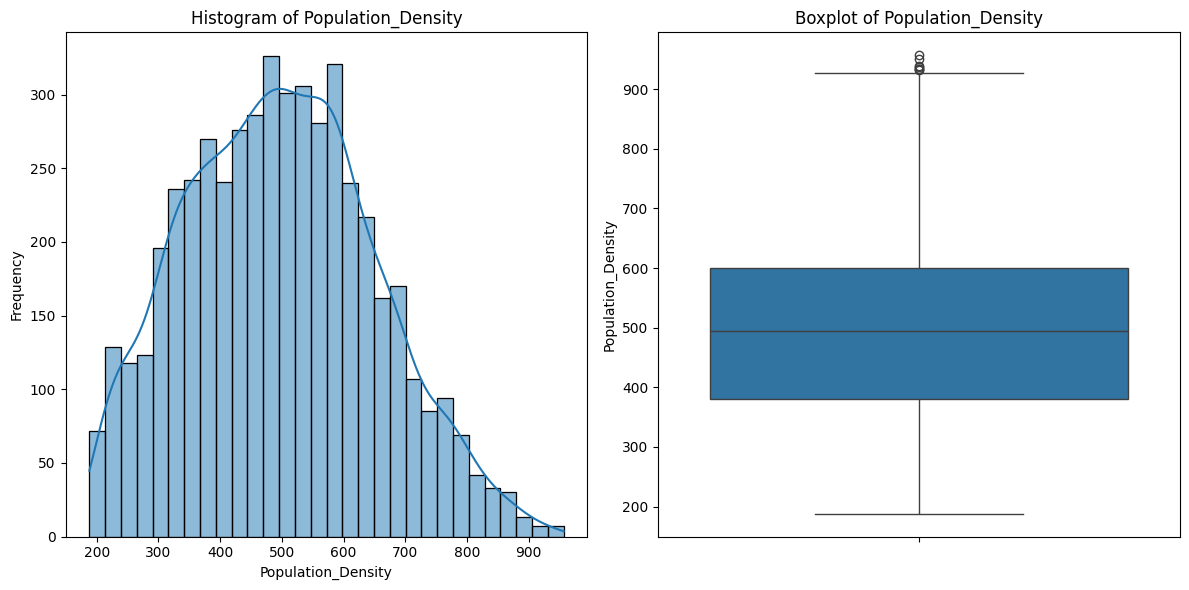

In [ ]:
eda_univariate_numeric(df)

CORRELATION

In [ ]:


def multivariate_analysis_numeric_heatmap(df):
    numeric_columns = df.select_dtypes(include=['number']).columns
    corr_matrix = df[numeric_columns].corr()
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Heatmap of Correlation Matrix for Numerical Columns')
    plt.show()



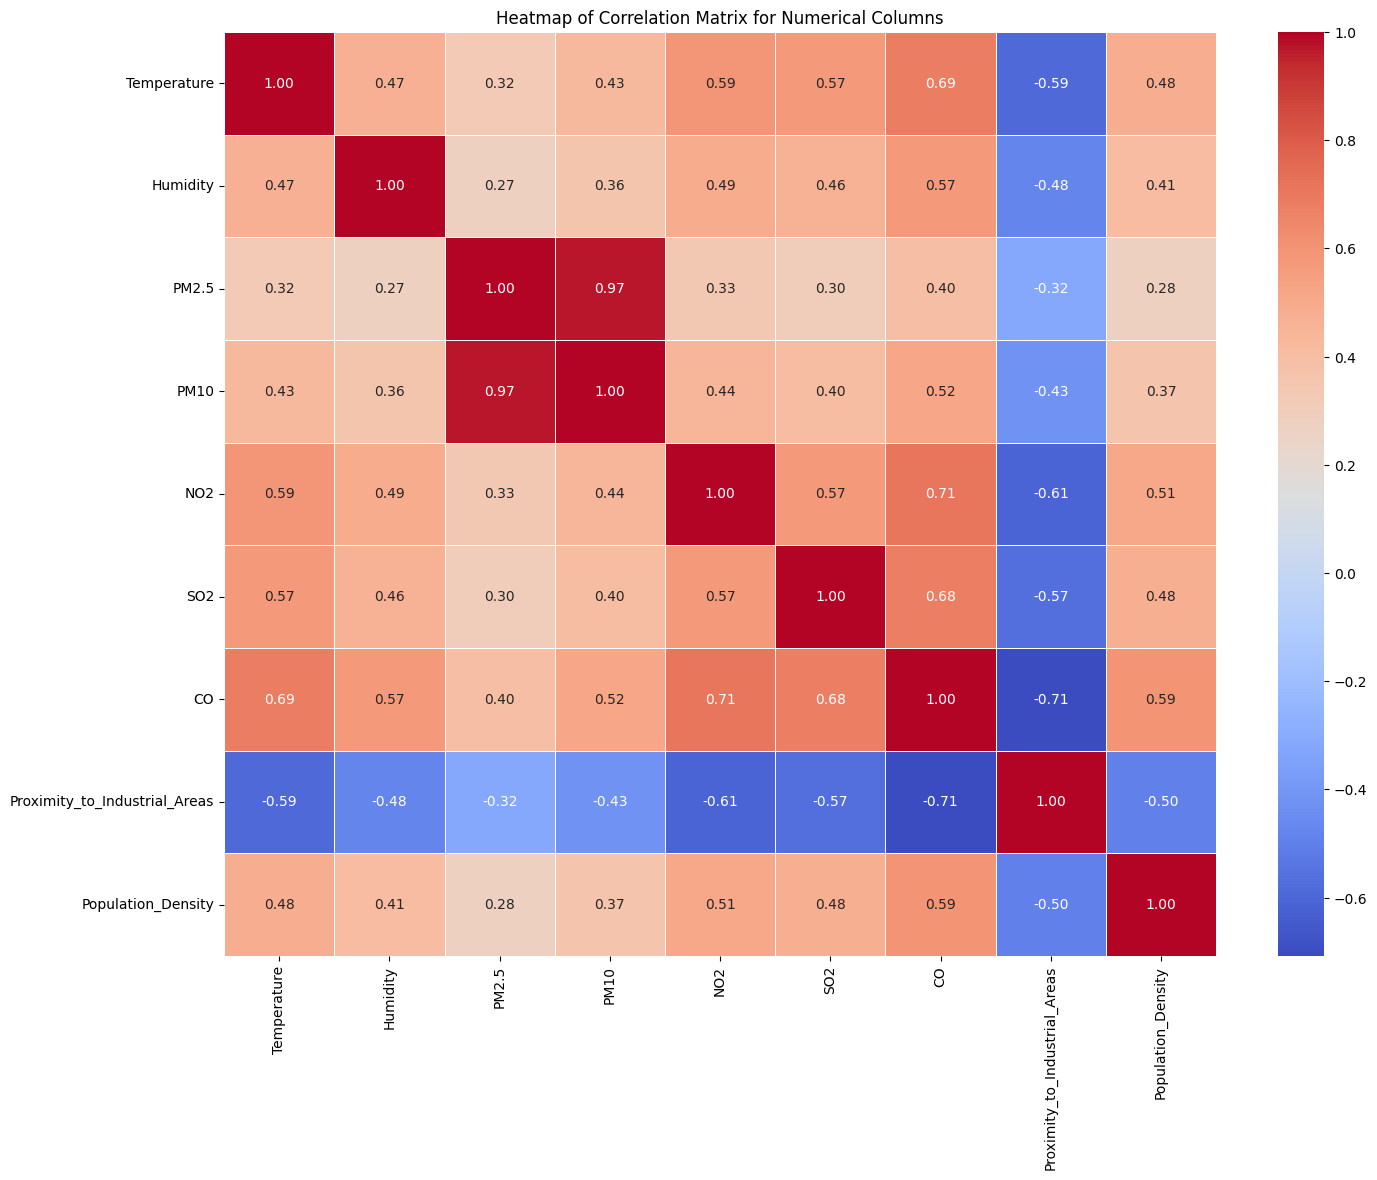

In [ ]:
multivariate_analysis_numeric_heatmap(df)



Hasil visualisasi data menunjukan pada fitur PM2.5 dan PM10 dengan korelasi positif kuat sebesar 97%


DATA PREPARATION SPLITTING DATA



Pada tahap preparation, hanya label target yang dilakukan label encoding untuk mengubah bentuk data dari kategorikal menjadi numerik. Outlier tidak dihapus karena distribusi data yang memiliki kemiringan ekstrem. Penghapusan outlier berpotensi menghilangkan informasi penting dari data.


In [ ]:


label_encoder = LabelEncoder()
df['Air_Quality_Encoded'] = label_encoder.fit_transform(df['Air Quality'])



In [ ]:


X = df.drop(['Air Quality', 'Air_Quality_Encoded'], axis=1)
y = df['Air_Quality_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



SMOTE

In [ ]:


smote = SMOTE(random_state=42)
X_train_rf, y_train_rf = smote.fit_resample(X_train, y_train)



RANDOM FOREST

In [ ]:
def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }

    model = RandomForestClassifier(**param)
    model.fit(X_train_rf, y_train_rf)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    return report['macro avg']['f1-score']

In [ ]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50, timeout=3600)

print("\nRandom Forest Best Hyperparameters:", study_rf.best_params)
print("Random Forest Best F1-Score:", study_rf.best_value)

[I 2025-01-20 12:34:27,662] A new study created in memory with name: no-name-1f7172a0-d979-41a7-81a7-c4012af562fc
[I 2025-01-20 12:34:59,524] Trial 0 finished with value: 0.9225564372027917 and parameters: {'n_estimators': 377, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.9225564372027917.
[I 2025-01-20 12:35:08,922] Trial 1 finished with value: 0.8966922124593765 and parameters: {'n_estimators': 285, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.9225564372027917.
[I 2025-01-20 12:35:20,494] Trial 2 finished with value: 0.8721716746036136 and parameters: {'n_estimators': 461, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.9225564372027917.
[I 2025-01-20 12:35:33,113] Trial 3 finished with value: 0.8966922124593765 and parameters: {'n_estimators': 397, 'max_depth': 7, 'min_sample


Random Forest Best Hyperparameters: {'n_estimators': 244, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Random Forest Best F1-Score: 0.9399087264001562


In [ ]:


rf_final = RandomForestClassifier(**study_rf.best_params)
rf_final.fit(X_train_rf, y_train_rf)

rf_y_train_pred = rf_final.predict(X_train_rf)
rf_y_test_pred = rf_final.predict(X_test)

rf_train_f1 = f1_score(y_train_rf, rf_y_train_pred, average='macro')
rf_test_f1 = f1_score(y_test, rf_y_test_pred, average='macro')

print(f"\nRandom Forest Training F1-Score: {rf_train_f1:.2f}")
print(f"Random Forest Testing F1-Score: {rf_test_f1:.2f}")

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_y_test_pred))




Random Forest Training F1-Score: 0.99
Random Forest Testing F1-Score: 0.93

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       409
           1       0.86      0.94      0.90       111
           2       0.97      0.96      0.96       294
           3       0.89      0.86      0.88       186

    accuracy                           0.95      1000
   macro avg       0.93      0.94      0.93      1000
weighted avg       0.96      0.95      0.96      1000



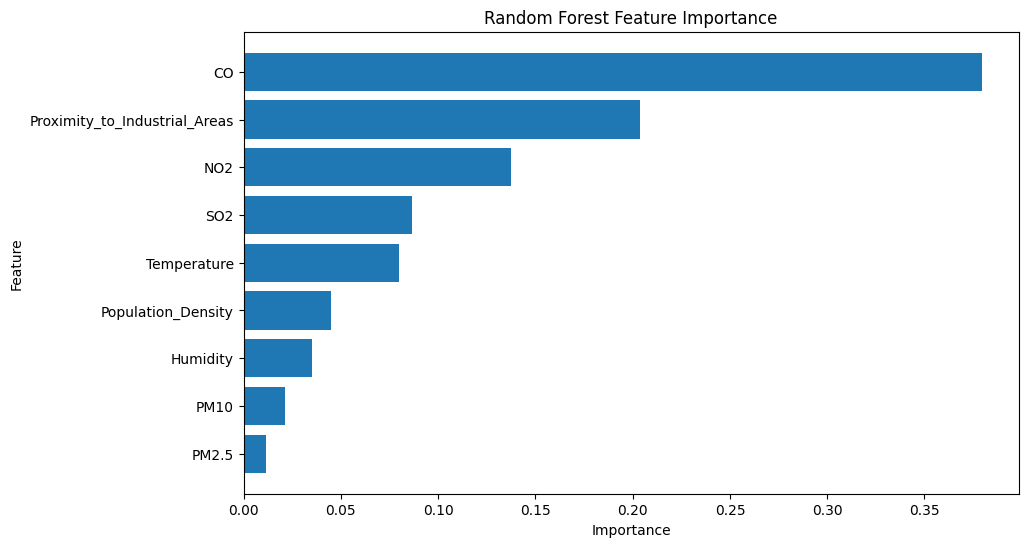


Random Forest Feature Importance:
                         Feature  Importance
6                             CO    0.379445
7  Proximity_to_Industrial_Areas    0.203944
4                            NO2    0.137458
5                            SO2    0.086527
0                    Temperature    0.079960
8             Population_Density    0.044961
1                       Humidity    0.035248
3                           PM10    0.021171
2                          PM2.5    0.011286


In [ ]:
feature_importances_rf = rf_final.feature_importances_

feature_names = X_train_rf.columns
importance_rf_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_rf
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_rf_df['Feature'], importance_rf_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

print("\nRandom Forest Feature Importance:")
print(importance_rf_df)

SIMPAN MODEL

In [ ]:
import joblib

In [ ]:

# Save the trained Random Forest model (rf_final)
joblib.dump(rf_final, 'random_forest_model.pkl')

['random_forest_model.pkl']